In [ ]:
import numpy as np
import pandas as pd
#importing modules
import os
import pandas as pd
import seaborn as sns
import os
import shutil
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,TimeDistributed, Flatten, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.regularizers import l2
import re

In [ ]:
train_dataset = pd.read_csv('/content/drive/MyDrive/NLP (1)/Tweets.csv')


In [ ]:
train_dataset.head()


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
train_dataset.tail()


,textID,text,selected_text,sentiment
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral


In [ ]:
train_dataset.shape


(27481, 4)

In [ ]:
#checking if there are any null values
train_dataset.isnull().any()

textID           False
text              True
selected_text     True
sentiment        False
dtype: bool

In [ ]:
#checking out number of negative, neutral and positive sentiment labels in the dataset.
print("Number of positive sentiment in train data of length: {0} is {1}".format(len(train_dataset), len(train_dataset[train_dataset['sentiment']=="positive"])))
print("Number of negative sentiment in train data of length: {0} is {1}".format(len(train_dataset), len(train_dataset[train_dataset['sentiment']=="neutral"])))
print("Number of neutral sentiment in train data of length: {0} is {1}".format(len(train_dataset), len(train_dataset[train_dataset['sentiment']=="negative"])))


Number of positive sentiment in train data of length: 27481 is 8582
Number of negative sentiment in train data of length: 27481 is 11118
Number of neutral sentiment in train data of length: 27481 is 7781


<Axes: xlabel='sentiment'>

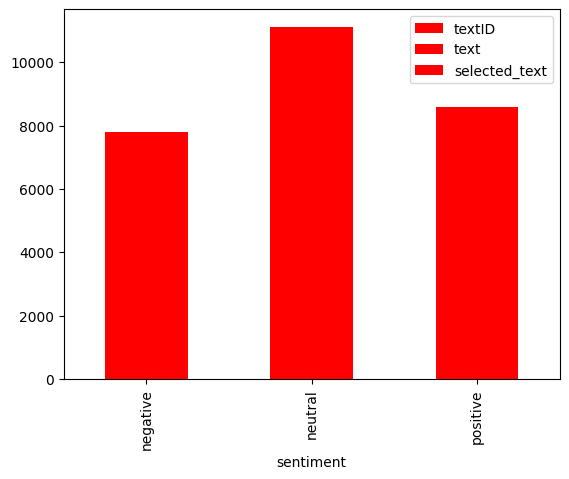

In [ ]:

#plotting the same.
train_dataset.groupby('sentiment').count().plot.bar(color='red')

<ipython-input-11-65b4696ea094>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_dataset.text.str.len())


<Axes: xlabel='text', ylabel='Density'>

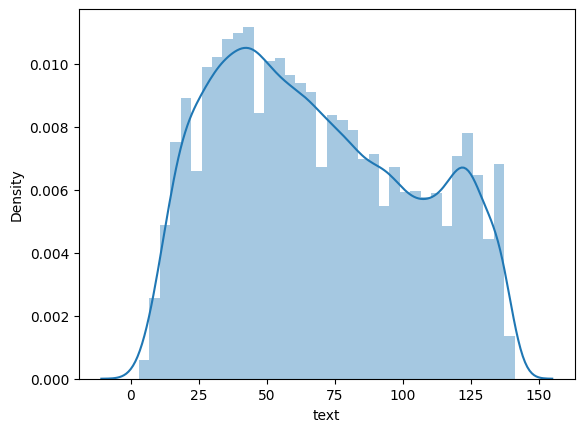

In [ ]:
#plotting the distibution of number of characters in the tweets
sns.distplot(train_dataset.text.str.len())

In [ ]:
#dropping unneccessary columns
train_dataset = train_dataset.drop(['textID','selected_text'],axis=1)
train_dataset.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


**Tokenisation**

In [ ]:
#converting data in text column to string
train_dataset.text=train_dataset.text.astype(str)
train_dataset.text = train_dataset.text.str.lower()
#cleaning more
train_dataset['text'] = train_dataset['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


<Axes: xlabel='sentiment'>

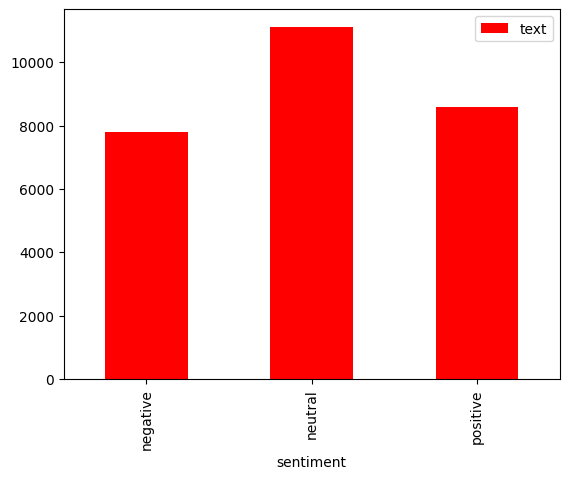

In [ ]:
train_dataset.groupby('sentiment').count().plot.bar(color='red')


In [ ]:
max_features = 5000
# removing unneccessary punctuations while tokenizing
tokenizer = Tokenizer(num_words= max_features, oov_token='OOV',filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(train_dataset['text'].values)
features = tokenizer.texts_to_sequences(train_dataset['text'].values)
features = pad_sequences(features,padding='post')


In [ ]:
max_features = 5000
# removing unneccessary punctuations while tokenizing
tokenizer2 = Tokenizer(num_words= max_features, oov_token='OOV',filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~')
tokenizer2.fit_on_texts(train_dataset_without_neutral['text'].values)
features2 = tokenizer2.texts_to_sequences(train_dataset_without_neutral['text'].values)
features2 = pad_sequences(features2,padding='post')

In [ ]:
#getting numerical data for labels
labels = pd.get_dummies(train_dataset['sentiment']).values
X_train, X_val, Y_train, Y_val = train_test_split(features,labels, test_size = 0.33, random_state = 42)
X_train1, X_val1, Y_train1, Y_val1 = train_test_split(features,labels, test_size = 0.33, random_state = 42)

print("Input training features and label shape are {},{}".format(X_train.shape,Y_train.shape))
print("Input validation features and label shape are {}, {}".format(X_val.shape,Y_val.shape))

print("Input training features and label shape are {},{}".format(X_train1.shape,Y_train1.shape))
print("Input validation features and label shape are {}, {}".format(X_val1.shape,Y_val1.shape))

Input training features and label shape are (18412, 34),(18412, 3)
Input validation features and label shape are (9069, 34), (9069, 3)
Input training features and label shape are (18412, 34),(18412, 3)
Input validation features and label shape are (9069, 34), (9069, 3)


**LSTM**

In [ ]:
vocab_size = len(tokenizer.word_index)+1 # 1 for that extra OOV


In [ ]:
# main model
LSTM_model = Sequential()
LSTM_model.add(Embedding(vocab_size,100,input_length = features2.shape[1]))
LSTM_model.add(LSTM (100,return_sequences=True,dropout=0.2,recurrent_dropout=0.2, kernel_regularizer=l2(0.1)))
LSTM_model.add(TimeDistributed(Dense(100,activation='relu')))
LSTM_model.add(SpatialDropout1D(0.4))
LSTM_model.add(Flatten())
LSTM_model.add(Dense(2,activation='softmax'))
LSTM_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
LSTM_model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 33, 100)           2873100   
                                                                 
 lstm_3 (LSTM)               (None, 33, 100)           80400     
                                                                 
 time_distributed_5 (TimeDi  (None, 33, 100)           10100     
 stributed)                                                      
                                                                 
 spatial_dropout1d_5 (Spati  (None, 33, 100)           0         
 alDropout1D)                                                    
                                                                 
 flatten_5 (Flatten)         (None, 3300)              0         
                                                                 
 dense_11 (Dense)            (None, 2)                

In [ ]:
batch_size = 256
LSTM_model_history = LSTM_model.fit(X_train1,Y_train1, epochs = 6, batch_size=batch_size, verbose=1, validation_data=(X_val1,Y_val1))


Epoch 1/6
43/43 [==============================] - 39s 732ms/step - loss: 19.0371 - accuracy: 0.6090 - val_loss: 8.7792 - val_accuracy: 0.7954
Epoch 2/6
43/43 [==============================] - 32s 759ms/step - loss: 4.6424 - accuracy: 0.8564 - val_loss: 2.0274 - val_accuracy: 0.8328
Epoch 3/6
43/43 [==============================] - 31s 715ms/step - loss: 1.0385 - accuracy: 0.9052 - val_loss: 0.6211 - val_accuracy: 0.8498
Epoch 4/6
43/43 [==============================] - 32s 750ms/step - loss: 0.3404 - accuracy: 0.9177 - val_loss: 0.4408 - val_accuracy: 0.8474
Epoch 5/6
43/43 [==============================] - 33s 772ms/step - loss: 0.2168 - accuracy: 0.9317 - val_loss: 0.4509 - val_accuracy: 0.8426
Epoch 6/6
43/43 [==============================] - 31s 720ms/step - loss: 0.1765 - accuracy: 0.9435 - val_loss: 0.4040 - val_accuracy: 0.8441


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef
# Model Prediction
y_pred_lstm = LSTM_model.predict(X_val1)
y_pred_lstm_binary = (y_pred_lstm.argmax(axis=1))

# Accuracy
accuracy_lstm = accuracy_score(Y_val1.argmax(axis=1), y_pred_lstm_binary)
print(f"Accuracy: {accuracy_lstm}")

# Recall
recall_lstm = recall_score(Y_val1.argmax(axis=1), y_pred_lstm_binary, average='weighted')  # Use average='weighted' for multiclass
print(f"Recall: {recall_lstm}")

# Precision
precision_lstm = precision_score(Y_val1.argmax(axis=1), y_pred_lstm_binary, average='weighted')  # Use average='weighted' for multiclass
print(f"Precision: {precision_lstm}")

# F1 Score
f1_lstm = f1_score(Y_val1.argmax(axis=1), y_pred_lstm_binary, average='weighted')  # Use average='weighted' for multiclass
print(f"F1 Score: {f1_lstm}")

# AUC (Area Under the Curve)
auc_lstm = roc_auc_score(Y_val1, y_pred_lstm, multi_class='ovr')  # Use multi_class='ovr' for multiclass
print(f"AUC: {auc_lstm}")

# Kappa
kappa_lstm = cohen_kappa_score(Y_val1.argmax(axis=1), y_pred_lstm_binary)
print(f"Kappa: {kappa_lstm}")

# MCC (Matthews Correlation Coefficient)
mcc_lstm = matthews_corrcoef(Y_val1.argmax(axis=1), y_pred_lstm_binary)
print(f"MCC: {mcc_lstm}")

169/169 [==============================] - 4s 23ms/step
Accuracy: 0.8440740740740741
Recall: 0.8440740740740741
Precision: 0.8454417269909896
F1 Score: 0.8440887043235095
AUC: 0.9240667877285786
Kappa: 0.6883915788694566
MCC: 0.689483318568866


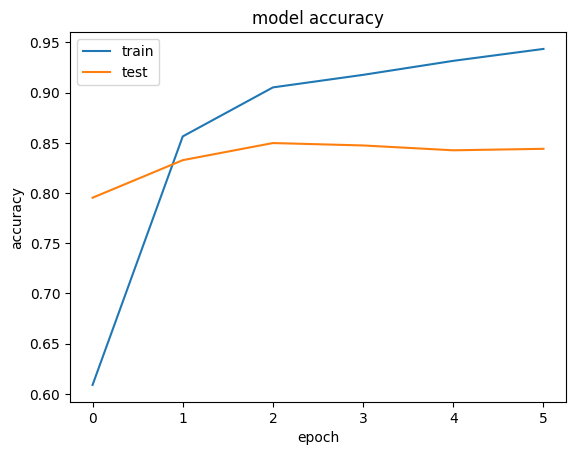

In [ ]:

plt.plot(LSTM_model_history.history['accuracy'])
plt.plot(LSTM_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

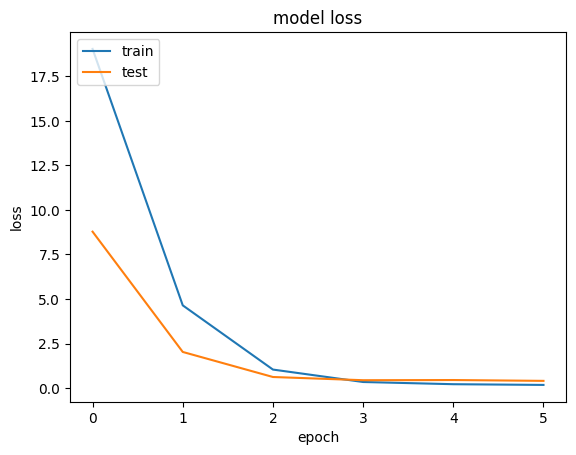

In [ ]:
# summarize history for loss
plt.plot(LSTM_model_history.history['loss'])
plt.plot(LSTM_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**GRU**

In [ ]:
from keras.layers import GRU

# main model
GRU_model = Sequential()
GRU_model.add(Embedding(vocab_size, 100, input_length=features2.shape[1]))
GRU_model.add(GRU(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.1)))
GRU_model.add(TimeDistributed(Dense(100, activation='relu')))
GRU_model.add(SpatialDropout1D(0.4))
GRU_model.add(Flatten())
GRU_model.add(Dense(2, activation='softmax'))
GRU_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
GRU_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 33, 100)           2873100   
                                                                 
 gru_2 (GRU)                 (None, 33, 100)           60600     
                                                                 
 time_distributed_2 (TimeDi  (None, 33, 100)           10100     
 stributed)                                                      
                                                                 
 spatial_dropout1d_2 (Spati  (None, 33, 100)           0         
 alDropout1D)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 3300)              0         
                                                                 
 dense_5 (Dense)             (None, 2)                

In [ ]:
batch_size = 256
GRU_model_history = GRU_model.fit(X_train1,Y_train1, epochs = 6, batch_size=batch_size, verbose=1, validation_data=(X_val1,Y_val1))


Epoch 1/6
43/43 [==============================] - 59s 1s/step - loss: 18.9210 - accuracy: 0.5931 - val_loss: 9.6443 - val_accuracy: 0.7780
Epoch 2/6
43/43 [==============================] - 41s 973ms/step - loss: 5.5084 - accuracy: 0.8376 - val_loss: 2.6513 - val_accuracy: 0.8513
Epoch 3/6
43/43 [==============================] - 28s 655ms/step - loss: 1.4616 - accuracy: 0.9048 - val_loss: 0.8573 - val_accuracy: 0.8402
Epoch 4/6
43/43 [==============================] - 27s 629ms/step - loss: 0.4605 - accuracy: 0.9217 - val_loss: 0.4935 - val_accuracy: 0.8431
Epoch 5/6
43/43 [==============================] - 27s 631ms/step - loss: 0.2570 - accuracy: 0.9256 - val_loss: 0.4117 - val_accuracy: 0.8506
Epoch 6/6
43/43 [==============================] - 29s 672ms/step - loss: 0.1934 - accuracy: 0.9407 - val_loss: 0.4465 - val_accuracy: 0.8402


In [ ]:
# Model Prediction
y_pred_GRU = GRU_model.predict(X_val1)
y_pred_GRU_binary = (y_pred_GRU.argmax(axis=1))


# Accuracy
accuracy_GRU = accuracy_score(Y_val1.argmax(axis=1), y_pred_GRU_binary)
print(f"Accuracy: {accuracy_GRU}")

# Recall
recall_GRU = recall_score(Y_val1.argmax(axis=1), y_pred_GRU_binary, average='weighted')  # Use average='weighted' for multiclass
print(f"Recall: {recall_GRU}")

# Precision
precision_GRU = precision_score(Y_val1.argmax(axis=1), y_pred_GRU_binary, average='weighted')  # Use average='weighted' for multiclass
print(f"Precision: {precision_GRU}")

# F1 Score
f1_GRU = f1_score(Y_val1.argmax(axis=1), y_pred_GRU_binary, average='weighted')  # Use average='weighted' for multiclass
print(f"F1 Score: {f1_GRU}")

# AUC (Area Under the Curve)
auc_GRU = roc_auc_score(Y_val1, y_pred_GRU, multi_class='ovr')  # Use multi_class='ovr' for multiclass
print(f"AUC: {auc_GRU}")

# Kappa
kappa_GRU = cohen_kappa_score(Y_val1.argmax(axis=1), y_pred_GRU_binary)
print(f"Kappa: {kappa_GRU}")

# MCC (Matthews Correlation Coefficient)
mcc_GRU = matthews_corrcoef(Y_val1.argmax(axis=1), y_pred_GRU_binary)
print(f"MCC: {mcc_GRU}")

169/169 [==============================] - 4s 21ms/step
Accuracy: 0.8401851851851851
Recall: 0.8401851851851851
Precision: 0.8465101878475559
F1 Score: 0.8398482090797148
AUC: 0.9255772009982459
Kappa: 0.6813438234638491
MCC: 0.687006297729992


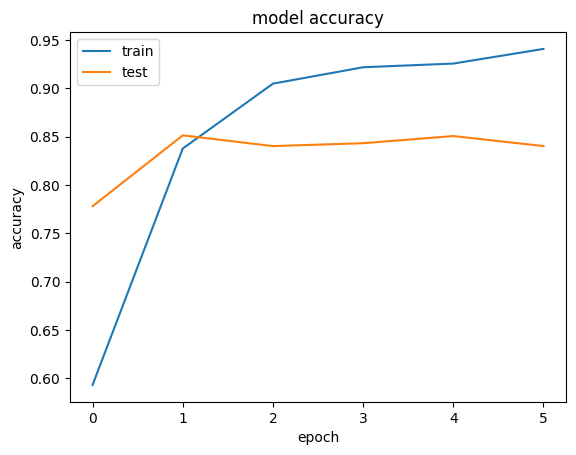

In [ ]:

plt.plot(GRU_model_history.history['accuracy'])
plt.plot(GRU_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

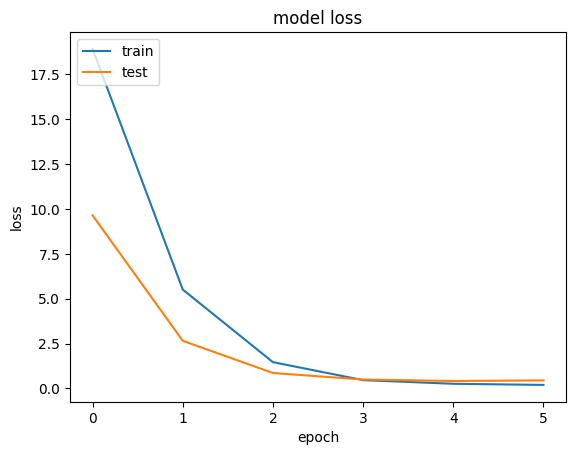

In [ ]:
# summarize history for loss
plt.plot(GRU_model_history.history['loss'])
plt.plot(GRU_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()